# Nortek AD2CP Processing Code
##### jgradone@marine.rutgers.edu     01/11/2022    Initial

This Jupyter Notebook is intended to read in AD2CP data processed to NetCDFs using the Nortek MIDAS software. The plan will eventually be to seperate a lot of these steps into different functions in a cleaned up packaged that can be published on GitHub but for now, this notebook will include most troubleshooting/processing steps here.

In [1]:
# Imports
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import dask.array as da
from erddapy import ERDDAP
#from RU29_helpers import grid_glider
#import cmocean.cm as cmo

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

# Load data files
## Glider data first, this was created on my local computer where I just loaded through all the dbds and only pulled out start time, end time, start lat, start lon, end lat, end lon, and the depth averaged velocities (vx and vy) from the end of the segment.

In [2]:
gl1 = pd.read_csv('/home/jg1200/Data/GliderData/RU29/RU29_2020_vx_vy_lat_lon.csv',usecols=[1,2,3,4,5,6,7,8])
gl1

,start_tm,end_tm,start_lat,start_lon,end_lat,end_lon,end_vx,end_vy
0,2020-09-08 15:29:32.766754048,2020-09-08 15:48:35.365783808,18.170002,-64.796574,18.171467,-64.797777,-0.140862,0.115427
1,2020-09-08 16:24:48.429809664,2020-09-08 16:53:24.328765952,18.175290,-64.802942,18.176025,-64.802830,-0.074237,0.037482
2,2020-09-08 17:08:26.503631616,2020-09-08 17:40:48.899688704,18.176050,-64.802863,18.177313,-64.803195,-0.104293,0.060243
3,2020-09-08 17:52:08.479034368,2020-09-08 18:25:41.044586240,18.177320,-64.803227,18.177777,-64.803195,-0.073689,0.021219
4,2020-09-08 18:29:04.142639104,2020-09-08 19:12:35.589019648,18.177805,-64.803217,18.177313,-64.799267,-0.078872,0.025200
...,...,...,...,...,...,...,...,...
542,2020-11-16 06:46:20.681335552,2020-11-16 08:03:26.950988800,NaN,NaN,18.149488,-64.790730,-0.043635,-0.000011
543,2020-11-16 08:14:06.041015552,2020-11-16 09:29:23.623840256,NaN,NaN,18.160925,-64.788282,-0.032541,-0.012039
544,2020-11-16 09:38:16.354126080,2020-11-16 10:56:29.950866688,NaN,NaN,18.168160,-64.786373,0.002537,-0.010122
545,2020-11-16 11:05:57.337615872,2020-11-16 12:21:20.608947712,NaN,NaN,18.163325,-64.788422,-0.039627,0.010190


## AD2CP data now

In [3]:
fname = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Combined/RU29_2020_AD2CP_Combined.nc"
tot_ad2cp = xr.open_dataset(fname)

tot_ad2cp

<xarray.Dataset>
Dimensions:           (time: 11580371, beams: 4, xyz: 4, ahrs_rot_mat_dim: 9, bins: 40)
Coordinates:
  * bins              (bins) float32 0.7 1.2 1.7 2.2 2.7 ... 18.7 19.2 19.7 20.2
  * time              (time) datetime64[ns] 2020-09-08T17:52:48.032099008 ......
  * beams             (beams) int64 1 2 3 4
  * xyz               (xyz) int64 1 2 3 4
  * ahrs_rot_mat_dim  (ahrs_rot_mat_dim) int64 0 1 2 3 4 5 6 7 8
Data variables: (12/20)
    heading           (time) float32 ...
    depth             (time) float64 ...
    pitch             (time) float32 ...
    roll              (time) float32 ...
    speedofsound      (time) float32 ...
    blanking          (time) float64 ...
    ...                ...
    beam3cor          (bins, time) float32 ...
    beam4cor          (bins, time) float32 ...
    beam1amp          (bins, time) float32 ...
    beam2amp          (bins, time) float32 ...
    beam3amp          (bins, time) float32 ...
    beam4amp          (bins, time) float32 ...

## This is where I resaved the ad2cp netcdfs and slightly smaller netcdfs that can be read in xarray and easily stuffed together to make one massive netcdf

In [4]:
# #path = '/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/Glider/RU_29/Nortek_Recovered/processed/'
# path = '/home/jg1200/Data/GliderData/RU29/2021_02_17_ru_29_614_post_UVI/'

# files = glob.glob(path+'*.nc')
# files = np.sort(files)

In [5]:
# def load_ad2cp_nc(file_name):
#     ds = nc.Dataset(file_name)
#     #ds = xr.open_mfdataset(file_name, autoclose=True)

    
#     tm                 = np.array(ds['Data']['Burst'].variables['time'])
#     tm                 = pd.to_datetime(tm, unit='s').values
#     pressure           = np.array(ds['Data']['Burst'].variables['Pressure'])
#     heading            = np.array(ds['Data']['Burst'].variables['Heading'])
#     pitch              = np.array(ds['Data']['Burst'].variables['Pitch'])
#     roll               = np.array(ds['Data']['Burst'].variables['Roll'])
#     roll               = roll-180 # Note: the AD2CP baseline roll is at 180 so must subtract 180 from roll first
#     bins               = np.array(ds['Data']['Burst'].variables['Velocity Range'])
#     bins               = np.round(bins,2) ## Doing this because there are some weird 3.999's and I want a regular 0.5 m grid
#     speedofsound       = np.array(ds['Data']['Burst'].variables['SpeedOfSound'])
#     blanking           = np.array(ds['Data']['Burst'].variables['Blanking'])
#     beam2xyz           = np.array(ds['Config'].burst_beam2xyz)
#     beam2xyz           = beam2xyz.reshape(4,4)   # Because we know this configuration is a 4 beam AD2CP
#     ahrs_rot_mat       = np.array(ds['Data']['Burst'].variables['AHRSRotationMatrix'])
    
#     beam1vel = np.array(ds['Data']['Burst'].variables['VelocityBeam1']).transpose()
#     beam2vel = np.array(ds['Data']['Burst'].variables['VelocityBeam2']).transpose()
#     beam3vel = np.array(ds['Data']['Burst'].variables['VelocityBeam3']).transpose()
#     beam4vel = np.array(ds['Data']['Burst'].variables['VelocityBeam4']).transpose()

#     beam1cor = np.array(ds['Data']['Burst'].variables['CorrelationBeam1']).transpose()
#     beam2cor = np.array(ds['Data']['Burst'].variables['CorrelationBeam2']).transpose()
#     beam3cor = np.array(ds['Data']['Burst'].variables['CorrelationBeam3']).transpose()
#     beam4cor = np.array(ds['Data']['Burst'].variables['CorrelationBeam4']).transpose()

#     beam1amp = np.array(ds['Data']['Burst'].variables['AmplitudeBeam1']).transpose()
#     beam2amp = np.array(ds['Data']['Burst'].variables['AmplitudeBeam2']).transpose()
#     beam3amp = np.array(ds['Data']['Burst'].variables['AmplitudeBeam3']).transpose()
#     beam4amp = np.array(ds['Data']['Burst'].variables['AmplitudeBeam4']).transpose()
    
#     df = xr.Dataset(
#         {"heading" : (("time"), heading),
#          "depth" : (("time"), pressure),
#          "pitch" : (("time"), pitch),
#          "roll" : (("time"), roll),
#          "speedofsound" : (("time"), speedofsound),
#          "blanking" : (("time"), blanking),
#          "beam2xyz" : (("beams","xyz"), beam2xyz),
#          "ahrs_rot_mat" : (("time","ahrs_rot_mat_dim"),ahrs_rot_mat),

#          "beam1vel" : (("bins","time"),beam1vel),
#          "beam2vel" : (("bins","time"),beam2vel),
#          "beam3vel" : (("bins","time"),beam3vel),
#          "beam4vel" : (("bins","time"),beam4vel),
#          "beam1cor" : (("bins","time"),beam1cor),
#          "beam2cor" : (("bins","time"),beam2cor),
#          "beam3cor" : (("bins","time"),beam3cor),
#          "beam4cor" : (("bins","time"),beam4cor),
#          "beam1amp" : (("bins","time"),beam1amp),
#          "beam2amp" : (("bins","time"),beam2amp),
#          "beam3amp" : (("bins","time"),beam3amp),
#          "beam4amp" : (("bins","time"),beam4amp)},    
#                  coords   = {"bins":bins,"time":tm,"beams":np.arange(1,5),"xyz":np.arange(1,5),"ahrs_rot_mat_dim":np.arange(0,9)}
#                            )
#     ds.close()
#     return(df)


In [6]:
# ## Loop to resave netcdfs

# for x in np.arange(0,len(files)):
#     df = load_ad2cp_nc(files[x])
#     fname = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/RU29_2020_AD2CP_{}.nc".format(x)
#     df.to_netcdf(fname)
#     print(x)


In [7]:
# # ## Attempt at smashing netcdfs together, amarel keeps crashing even with 50 gb of memeory
# nc_path = '/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/'
# ncfiles = glob.glob(nc_path+'*.nc')
# #tot_ad2cp = xr.merge([xr.open_mfdataset(f, autoclose=True) for f in ncfiles])
# tot_ad2cp = xr.open_mfdataset(ncfiles, concat_dim="time", combine="nested",
#                   data_vars='minimal', coords='minimal', compat='override')

# tot_ad2cp = tot_ad2cp.sortby('time')
# fname = "/home/jg1200/Data/GliderData/RU29/RU29_2020_AD2CP_NC/Combined/RU29_2020_AD2CP_Combined.nc"
# tot_ad2cp.to_netcdf(fname)



# Process!

## Now I'm going to:
1) Loop through the glider csv and pull out the depth average velocity components <br />
2) Use the corresponding start and end times to subset the massive ad2cp dataset <br />
3) Process the ad2cp data <br />
4) Inversion with depth average velocity constraint <br />

### Subset glider and ad2cp datasets to start at 10/15/2020, I know this is when the zig-zags between St. Thomas and St. Croix started

In [8]:
start_tm1 = '2020-10-14T00:00:00'
subset_ad2cp2 = tot_ad2cp.sel(time=slice(start_tm1, None))
#ind = gl1.start_tm.values > start_tm1

gl = gl1[gl1["start_tm"] > start_tm1]
gl.reset_index(drop=True, inplace=True)

In [9]:
# y=10
# start_tm = gl.start_tm[y]
# end_tm   = gl.end_tm[y]

# subset_adcp = subset_ad2cp2.sel(time=slice(start_tm, end_tm))


In [ ]:
## The only things that should need changing from run to run is dz and
## the DAC in the solution line if running only shear or DAC.

## Make sure path exists for saving data for different resolutions!!

##### Set Solution Resolution First!!!
dz = 5
bin_new = np.arange(2.5,1000+dz,dz)
len(bin_new)

inverted_u = np.empty([len(bin_new),len(gl.start_tm)])
inverted_u[:] = np.NaN
inverted_v = np.empty([len(bin_new),len(gl.start_tm)])
inverted_v[:] = np.NaN
inverted_time = np.empty(len(gl.start_tm))
inverted_time[:] = np.NaN
inverted_vx = np.empty(len(gl.start_tm))
inverted_vx[:] = np.NaN
inverted_vy = np.empty(len(gl.start_tm))
inverted_vy[:] = np.NaN
inverted_lon = np.empty(len(gl.start_tm))
inverted_lon[:] = np.NaN
inverted_lat = np.empty(len(gl.start_tm))
inverted_lat[:] = np.NaN



for y in np.arange(0, len(gl.start_tm)):
    start_tm = gl.start_tm[y]
    end_tm   = gl.end_tm[y]

    subset_adcp = subset_ad2cp2.sel(time=slice(start_tm, end_tm))
    if len(subset_adcp.time) > 0:
        vx = gl.end_vx[y]
        vy = gl.end_vy[y]

        beam1vel = subset_adcp.beam1vel.values
        beam2vel = subset_adcp.beam2vel.values
        beam3vel = subset_adcp.beam3vel.values
        beam4vel = subset_adcp.beam4vel.values

        ## Correct for speed of sound
        beam1vel = correct_sound_speed(beam1vel, subset_adcp.speedofsound.values, 1500)
        beam2vel = correct_sound_speed(beam2vel, subset_adcp.speedofsound.values, 1500)
        beam3vel = correct_sound_speed(beam3vel, subset_adcp.speedofsound.values, 1500)
        beam4vel = correct_sound_speed(beam4vel, subset_adcp.speedofsound.values, 1500)

        ## QAQC pre coordinate transform
        beam1vel, beam2vel, beam3vel, beam4vel = qaqc_pre_coord_transform(beam1vel,beam2vel,beam3vel,beam4vel,subset_adcp.beam1amp.values,subset_adcp.beam2amp.values,subset_adcp.beam3amp.values,subset_adcp.beam4amp.values,subset_adcp.pitch.values)

        ## Filter low correlation
        # Set threshold
        corr_threshold = 50

        beam1vel = xr.where(subset_adcp.beam1cor.values < corr_threshold, np.NaN, beam1vel)
        beam2vel = xr.where(subset_adcp.beam2cor.values < corr_threshold, np.NaN, beam2vel)
        beam3vel = xr.where(subset_adcp.beam3cor.values < corr_threshold, np.NaN, beam3vel)
        beam4vel = xr.where(subset_adcp.beam4cor.values < corr_threshold, np.NaN, beam4vel)

        ## Bin map
        for x in np.arange(0,beam1vel.shape[1]):
            beam1vel[:,x] = binmap_adcp(beam1vel[:,x],subset_adcp.pitch.values[x],subset_adcp['roll'].values[x],subset_adcp.bins.values)
            beam2vel[:,x] = binmap_adcp(beam2vel[:,x],subset_adcp.pitch.values[x],subset_adcp['roll'].values[x],subset_adcp.bins.values)
            beam3vel[:,x] = binmap_adcp(beam3vel[:,x],subset_adcp.pitch.values[x],subset_adcp['roll'].values[x],subset_adcp.bins.values)
            beam4vel[:,x] = binmap_adcp(beam4vel[:,x],subset_adcp.pitch.values[x],subset_adcp['roll'].values[x],subset_adcp.bins.values)

        ## Coordinate transform from beam to xyz to enu
        # Initialize final variables with NaNs first
        east             = np.empty([beam1vel.shape[0],beam1vel.shape[1]])
        north            = np.empty([beam1vel.shape[0],beam1vel.shape[1]])
        up               = np.empty([beam1vel.shape[0],beam1vel.shape[1]])
        east[:]          = np.NaN
        north[:]         = np.NaN
        up[:]            = np.NaN

        for k in np.arange(0,beam1vel.shape[1]):
            enu = beam2enu(beam1vel[:,k],beam2vel[:,k],beam3vel[:,k],beam4vel[:,k],beam2xyz=subset_adcp.beam2xyz.values,ahrs_rot_mat=subset_adcp.ahrs_rot_mat.values[k,:],pitch=subset_adcp.pitch.values[k])

            east[:,k]          = enu[0,:]
            north[:,k]         = enu[1,:]
            up[:,k]            = enu[2,:]

        ## QAQC Post-Coordinate Transformation
        east[east>0.5]   = np.NaN
        north[north>0.5] = np.NaN
        up[up>0.5]       = np.NaN

        # # ###################### Should add this to main function......
        
        ########################################################################################
        ### THIS IS A BIG DEAL!!!
        depth = subset_adcp.depth.values-10
        ########################################################################################
        
        bins = subset_adcp.bins.values

        #process_data(U=east.transpose(),V=north.transpose(),H=1000,dz=dz,u_daverage=vx,v_daverage=vy)
        process_data(U=east.transpose(),V=north.transpose(),H=1000,dz=dz,u_daverage=0,v_daverage=0)

        print(y)
        inverted_u[np.arange(0,len(np.real(O_ls))),y] = np.real(O_ls)
        inverted_v[np.arange(0,len(np.imag(O_ls))),y] = np.imag(O_ls)
        inverted_time[y] = np.datetime64(gl.end_tm[y])
        inverted_vx[y]   = gl.end_vx[y]
        inverted_vy[y]   = gl.end_vy[y]
        inverted_lat[y]  = gl.end_lat[y]
        inverted_lon[y]  = gl.end_lon[y]
        new_depth = bin_new
        
        
        inverted_u2    = np.real(O_ls)
        inverted_v2    = np.imag(O_ls)
        new_depth2     = bin_new

        inverted_time2 = pd.DatetimeIndex([gl.end_tm[y]])
        year          = str(inverted_time2.year.values)[1:-1]
        month         = str(inverted_time2.month.values)[1:-1]
        day           = str(inverted_time2.day.values)[1:-1]
        hour          = str(inverted_time2.hour.values)[1:-1]
        minute        = str(inverted_time2.minute.values)[1:-1]

        fname = "/home/jg1200/Data/GliderData/RU29/RU29_2020_Processed_Inversion_Shear_Only_{}m/RU29_2020_AD2CP_{}m_Inversion_{}_{}_{}_{}{}_Shear_Only.csv".format(dz,dz,year,month,day,hour,minute)
        #fname = "/home/jg1200/Data/GliderData/RU29/RU29_2020_Processed_Inversion_{}m/RU29_2020_AD2CP_{}m_Inversion_{}_{}_{}_{}{}.csv".format(dz,dz,year,month,day,hour,minute)

        ## Make into a dataframe to save as a CSV
        d = {'inverted_u': inverted_u2, 'inverted_v': inverted_v2, "bin_new": new_depth2}
        df = pd.DataFrame(data=d)
        df.to_csv(fname)  

        
        
## Now stuff them all together
fname = "/home/jg1200/Data/GliderData/RU29/RU29_2020_Processed_Inversion_Shear_Only_{}m/Total/RU29_2020_AD2CP_{}m_Inversion_Total_shear.nc".format(dz,dz)
#fname = "/home/jg1200/Data/GliderData/RU29/RU29_2020_Processed_Inversion_{}m/Total/RU29_2020_AD2CP_{}m_Inversion_Total.nc".format(dz,dz)

bin_new = np.arange(2.5,1000+dz,dz)

df = xr.Dataset(
    {"inverted_u": (("depth","time"), inverted_u),
    "inverted_v": (("depth", "time"), inverted_v)},
    coords = {"depth" : bin_new, "time" : inverted_time})

df.to_netcdf(fname)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


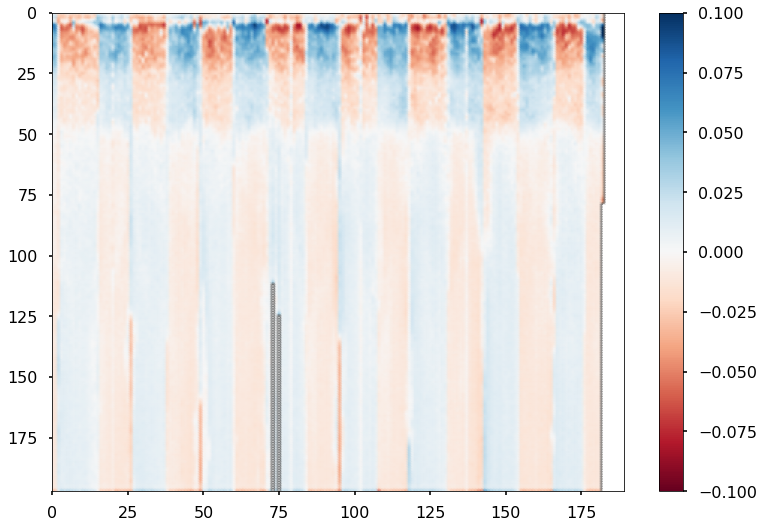

In [36]:
plt.pcolormesh(inverted_v[:,0:190], vmin=-0.1,vmax=0.1, cmap='RdBu',shading='gouraud')
plt.gca().invert_yaxis()
plt.colorbar()

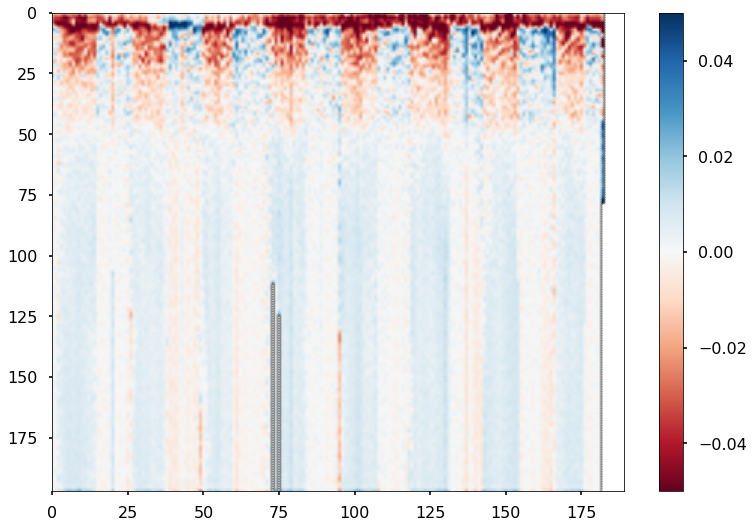

In [35]:
plt.pcolormesh(inverted_u[:,0:190], vmin=-0.05,vmax=0.05, cmap='RdBu', shading='gouraud')

#plt.pcolormesh(inverted_u, vmin=-0.05,vmax=0.05, cmap='RdBu')
plt.gca().invert_yaxis()
plt.colorbar()

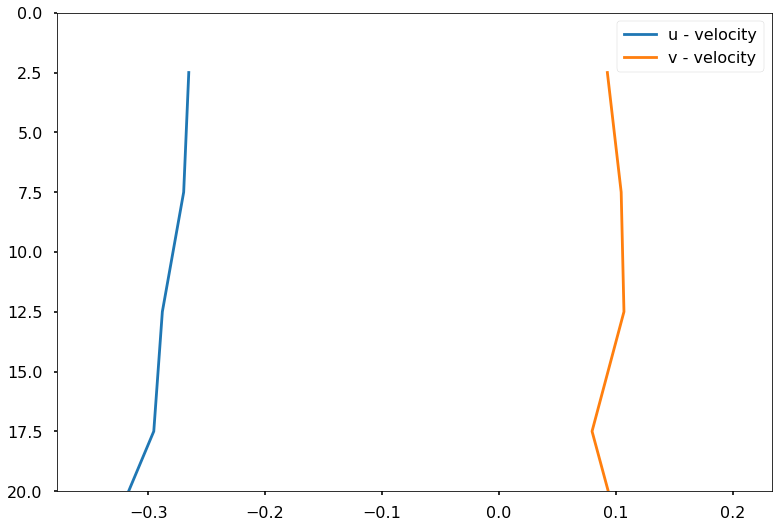

In [33]:

plt.plot(np.real(O_ls),bin_new,label='u - velocity')
plt.plot(np.imag(O_ls),bin_new,label='v - velocity')
plt.ylim(20,0)
plt.legend()


## Some testing

/tmp/ipykernel_18358/2582393931.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,0:1000],-by[:,0:1000],east[:,0:1000])


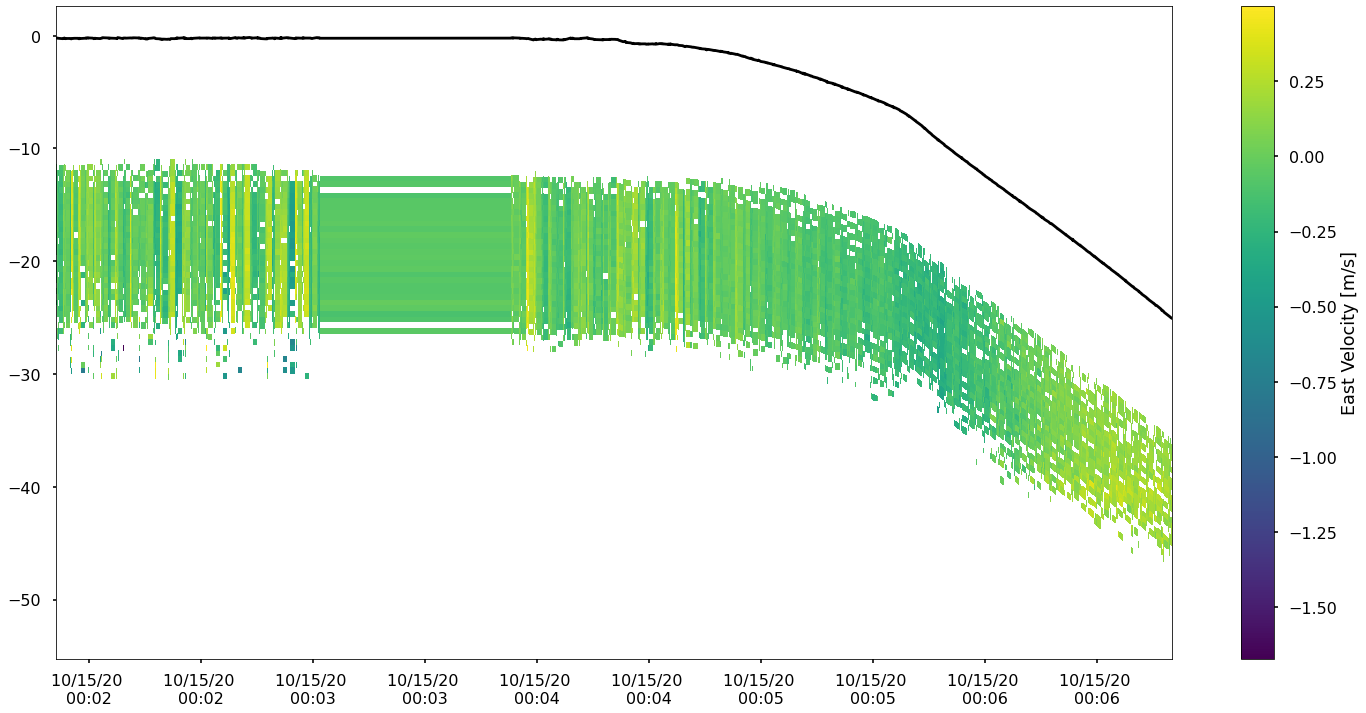

In [208]:
[x,y]=np.meshgrid(subset_adcp.time,subset_adcp.bins)
[bdepth,bbins]=np.meshgrid(subset_adcp.depth,subset_adcp.bins)

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x[:,0:1000],-by[:,0:1000],east[:,0:1000])
plt.plot(subset_adcp.time[0:1000],-subset_adcp.depth[0:1000]+10,'k')
plt.colorbar(label='East Velocity [m/s]')
plt.gca().xaxis.set_major_formatter(myFmtlong)


/tmp/ipykernel_18358/918344635.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,23500:25100],-by[:,23500:25100],east[:,23500:25100])


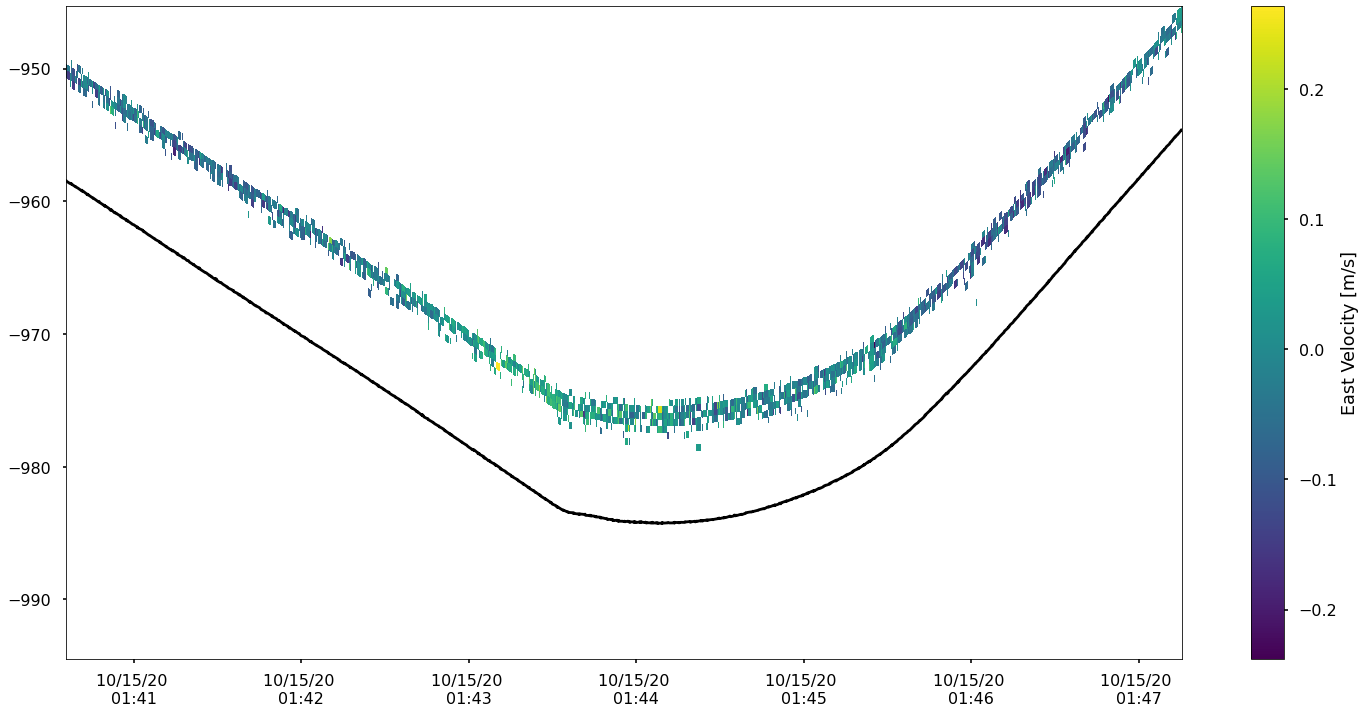

In [204]:

fig = plt.figure(figsize=(25,12))


plt.pcolormesh(x[:,23500:25100],-by[:,23500:25100],east[:,23500:25100])
plt.plot(subset_adcp.time[23500:25100],-subset_adcp.depth[23500:25100],'k')
plt.colorbar(label='East Velocity [m/s]')
plt.gca().xaxis.set_major_formatter(myFmtlong)

In [32]:
subset_adcp

<xarray.Dataset>
Dimensions:           (time: 44045, beams: 4, xyz: 4, ahrs_rot_mat_dim: 9, bins: 40)
Coordinates:
  * bins              (bins) float32 0.7 1.2 1.7 2.2 2.7 ... 18.7 19.2 19.7 20.2
  * time              (time) datetime64[ns] 2020-10-15T00:01:51.032200098 ......
  * beams             (beams) int64 1 2 3 4
  * xyz               (xyz) int64 1 2 3 4
  * ahrs_rot_mat_dim  (ahrs_rot_mat_dim) int64 0 1 2 3 4 5 6 7 8
Data variables: (12/20)
    heading           (time) float32 104.6 105.3 105.4 ... 132.6 131.7 130.4
    depth             (time) float64 10.21 10.2 10.2 10.2 ... 10.26 10.27 10.25
    pitch             (time) float32 -4.02 -2.61 -1.48 ... -3.63 -3.21 -2.6
    roll              (time) float32 -2.57 -2.91 -3.59 ... 0.08 -1.36 -3.67
    speedofsound      (time) float32 1.544e+03 1.544e+03 ... 1.544e+03 1.544e+03
    blanking          (time) float64 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2
    ...                ...
    beam3cor          (bins, time) float32 94.0 100.0 100.0 ... 38.0 29.0 34.0
    beam4cor          (bins, time) float32 100.0 100.0 25.0 ... 21.0 21.0 16.0
    beam1amp          (bins, time) float32 77.5 78.5 74.5 ... 33.0 33.5 33.5
    beam2amp          (bins, time) float32 76.0 77.5 78.0 ... 35.0 33.0 33.0
    beam3amp          (bins, time) float32 84.5 84.5 83.0 ... 34.0 34.5 33.5
    beam4amp          (bins, time) float32 72.0 78.5 78.0 ... 32.0 32.5 31.5

/tmp/ipykernel_18358/1915117691.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,25000:25100],-by[:,25000:25100],east[:,25000:25100])


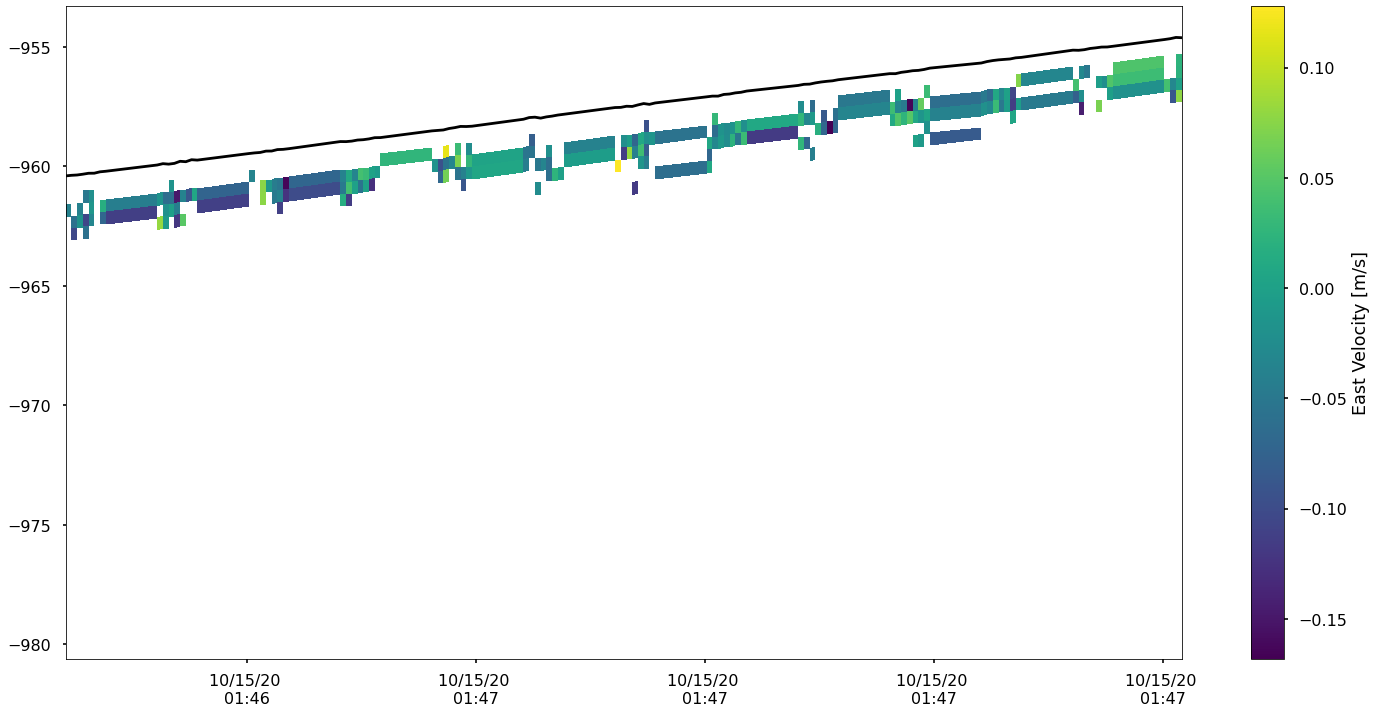

In [47]:

fig = plt.figure(figsize=(25,12))


plt.pcolormesh(x[:,25000:25100],-by[:,25000:25100],east[:,25000:25100])
plt.plot(subset_adcp.time[25000:25100],-subset_adcp.depth[25000:25100],'k')
plt.colorbar(label='East Velocity [m/s]')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Checking range

In [201]:
def check_max_beam_range(beam,bins):
    # For a single ping
    ind1 = np.argwhere(np.isnan(beam)==False)
    if len(ind1) == 0:
        beam_range = np.NaN
    elif len(ind1) > 0:
        ind2 = np.max(ind1[:,0])
        beam_range = bins[ind2]
    return(beam_range)

def check_max_beam_range_bins(beam,bins):
    # For a single ping
    ind1 = np.argwhere(np.isnan(beam)==False)
    if len(ind1) == 0:
        beam_range = np.NaN
    elif len(ind1) > 0:
        beam_range = np.max(ind1[:,0])
    return(beam_range)


##################################################################################################


def check_mean_beam_range(beam,bins):
    # For a single ping
    ind1 = np.argwhere(np.isnan(beam)==False)
    if len(ind1) == 0:
        beam_range = np.NaN
    elif len(ind1) > 0:
        ind2 = round(np.nanmean(ind1[:,0]))
        beam_range = bins[ind2]
    return(beam_range)

def check_mean_beam_range_bins(beam,bins):
    # For a single ping
    ind1 = np.argwhere(np.isnan(beam)==False)
    if len(ind1) == 0:
        beam_range = np.NaN
    elif len(ind1) > 0:
        beam_range = np.nanmean(ind1[:,0])
    return(beam_range)



Text(0.5, 0, 'Actual Max Range [m]')

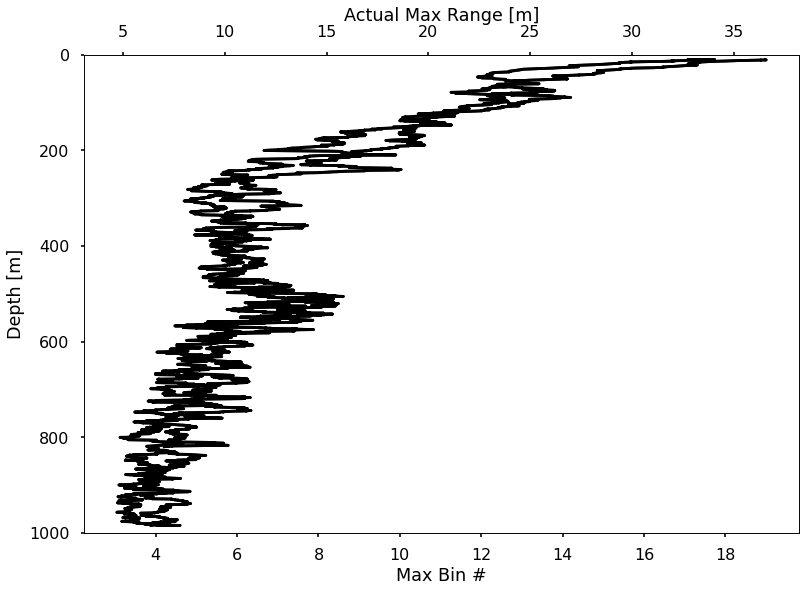

In [175]:
beam1_max_range = np.empty(beam1vel.shape[1])
beam1_max_range[:] = np.NaN

beam1_max_range_bins = np.empty(beam1vel.shape[1])
beam1_max_range_bins[:] = np.NaN

for x in np.arange(0,len(beam1_range)):
    beam1_max_range[x] = check_max_beam_range(beam1vel[:,x],bins)
    beam1_max_range_bins[x] = check_max_beam_range_bins(beam1vel[:,x],bins)

  

d1 = {'depth': subset_adcp.depth, 'beam1_max_range_bins': beam1_max_range_bins, 'beam1_max_range': beam1_max_range}
test_df = pd.DataFrame(data=d1)
test_df
bob = test_df.rolling(200).mean()

fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twiny()


lns1 = ax.plot(bob.beam1_max_range,bob.depth,label='# of bins',color='black')
lns2 = ax2.plot(bob.beam1_max_range_bins,bob.depth, label='actual range',color='black')
ax.set_ylim(1000,0)
#ax.set_xlim(20,0)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Max Bin #')
ax2.set_xlabel('Actual Max Range [m]')

Text(0.5, 0, 'Actual Mean Range [m]')

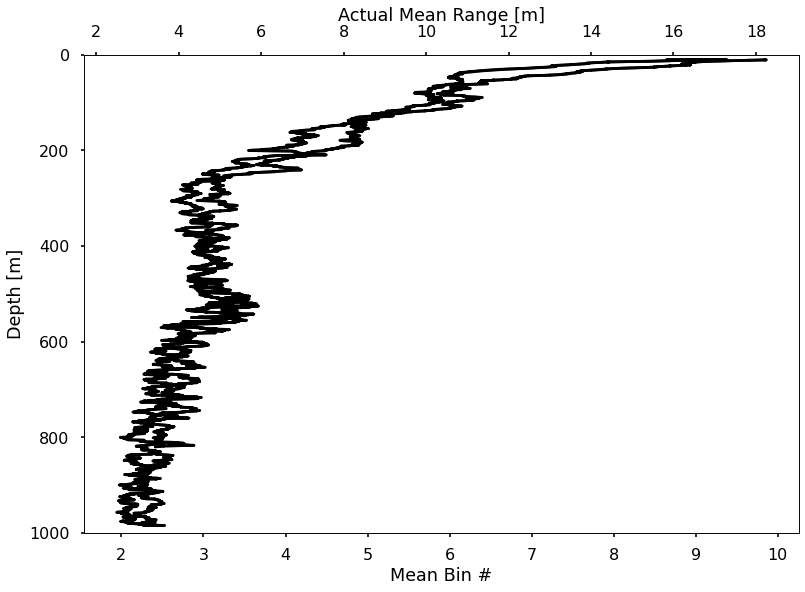

In [199]:
beam1_mean_range = np.empty(beam1vel.shape[1])
beam1_mean_range[:] = np.NaN

beam1_mean_range_bins = np.empty(beam1vel.shape[1])
beam1_mean_range_bins[:] = np.NaN

for x in np.arange(0,len(beam1_range)):
    beam1_mean_range[x] = check_mean_beam_range(beam1vel[:,x],bins)
    beam1_mean_range_bins[x] = check_mean_beam_range_bins(beam1vel[:,x],bins)

  

d1 = {'depth': subset_adcp.depth, 'beam1_mean_range_bins': beam1_mean_range_bins, 'beam1_mean_range': beam1_mean_range}
test_df = pd.DataFrame(data=d1)
test_df
bob = test_df.rolling(200).mean()

fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twiny()


lns1 = ax.plot(bob.beam1_mean_range,bob.depth,label='# of bins',color='black')
lns2 = ax2.plot(bob.beam1_mean_range_bins,bob.depth, label='actual range',color='black')
ax.set_ylim(1000,0)
#ax.set_xlim(20,0)
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Mean Bin #')
ax2.set_xlabel('Actual Mean Range [m]')

# Processing Step 1: Pitch Dependent Magnetic Correction for Heading
The pitch of the glider changes by moving the pitch-battery pack. The pitch-battery produces a magnetic field so when it moves, the field moves and this effects our compass data. Having all of the data from a mission loaded in for this correction ensures the best fit possible.

# Processing Step 2: QAQC Pre-Coordinate Transformation

## QAQC Step 1: Correct for local speed of sound (Fischer and Visbeck, 1993)
Where C is the real sound speed at the transducer, and CA is the speed of sound used by the ADCP. CA used by the Nortek AD2CP is 1500 m/s.

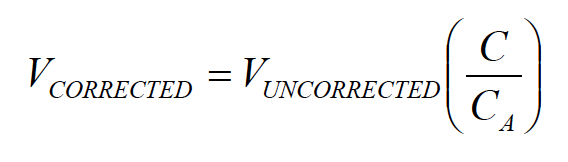

In [10]:
def correct_sound_speed(beamvelocity, real_speedofsound, default_speedofsound):
    vel = beamvelocity*(real_speedofsound/default_speedofsound)
    return vel


In [11]:
# beam1vel = correct_sound_speed(subset_adcp.beam1vel.values, subset_adcp.speedofsound.values, 1500)
# beam2vel = correct_sound_speed(subset_adcp.beam2vel.values, subset_adcp.speedofsound.values, 1500)
# beam3vel = correct_sound_speed(subset_adcp.beam3vel.values, subset_adcp.speedofsound.values, 1500)
# beam4vel = correct_sound_speed(subset_adcp.beam4vel.values, subset_adcp.speedofsound.values, 1500)

## QAQC Step 2: Filter for Extreme Amplitude Returns (Todd et al. 2017)

In [12]:
def qaqc_pre_coord_transform(beam1vel,beam2vel,beam3vel,beam4vel,beam1amp,beam2amp,beam3amp,beam4amp,pitch):
    pitch_threshold = 0
    
    # Set extreme amplitude threshold
    max_amplitude = 75 # [dB]
    
    for i in np.arange(0,beam1vel.shape[1]):
        if pitch[i] > pitch_threshold: # Upcast so use beams 234
            # If the return is above the threshold, flag the data
            amp2_ind = beam2amp[:,i] > max_amplitude 
            amp3_ind = beam3amp[:,i] > max_amplitude 
            amp4_ind = beam4amp[:,i] > max_amplitude
            amp_ind  = []
            amp_ind  = amp2_ind + amp3_ind + amp4_ind
            beam2vel[amp_ind,i] = np.NaN
            beam3vel[amp_ind,i] = np.NaN
            beam4vel[amp_ind,i] = np.NaN
        elif pitch[i] < pitch_threshold: # Downcast so use beams 124
            # If the return is above the threshold, flag the data
            amp1_ind = beam1amp[:,i] > max_amplitude 
            amp2_ind = beam2amp[:,i] > max_amplitude 
            amp4_ind = beam4amp[:,i] > max_amplitude
            amp_ind  = []
            amp_ind  = amp1_ind + amp2_ind + amp4_ind
            beam1vel[amp_ind,i] = np.NaN
            beam2vel[amp_ind,i] = np.NaN
            beam4vel[amp_ind,i] = np.NaN

    return(beam1vel,beam2vel,beam3vel,beam4vel)



In [13]:
# beam1vel, beam2vel, beam3vel, beam4vel = qaqc_pre_coord_transform(beam1vel,beam2vel,beam3vel,beam4vel,subset_adcp.beam1amp.values,subset_adcp.beam2amp.values,subset_adcp.beam3amp.values,subset_adcp.beam4amp.values,subset_adcp.pitch.values)


## QAQC Step 3: Correlation Filter (Todd et al. 2017)

Reject correlation values less than 0.5 (Todd et al. 2017). Do this directly to beam velocities.

In [14]:
# # Set threshold
# corr_threshold = 50

# beam1vel[subset_adcp.beam1cor.values < corr_threshold] = np.NaN
# beam2vel[subset_adcp.beam2cor.values < corr_threshold] = np.NaN
# beam3vel[subset_adcp.beam3cor.values < corr_threshold] = np.NaN
# beam4vel[subset_adcp.beam4cor.values < corr_threshold] = np.NaN

# Processing Step 3: Bin Mapping
Interpolate to set depth grid, this will also effectively filter out extreme pitch and roll

In [15]:
## Realized that the bins is really the projection along the vertical axis and it takes into account
## the transducer geometry already. For this function, just need to correct for vehicle pitch and roll.

def cell_vert(pitch, roll, bins):
    ## Calculate a vertical displacement below instrument for
    ## each adcp bin adjusting for pitch and roll (in degrees)
    ## Positive roll: Port wing up
    ## Positive pitch: Pitch up  
    
    pitch_adjusted = bins * np.sin(np.deg2rad(90-pitch))
    z = pitch_adjusted * np.sin(np.deg2rad(90-roll))    
    return z


In [16]:
def binmap_adcp(beamvelocity, pitch, roll, bins):
    ## bins = bin depths output from ADCP
    ## true_depth = Actual bin depths calculated with function cell_vert based on pitch and roll
    
    ## Comment this out better!
    
    true_depth = cell_vert(pitch, roll, bins)
    gridvel = interp.griddata(true_depth, beamvelocity, bins, method='nearest')
    return gridvel


## Loop to actually bin map beam velocities

In [17]:
# for x in np.arange(0,beam1vel.shape[1]):
#     beam1vel[:,x] = binmap_adcp(beam1vel[:,x],subset_adcp.pitch.values[x],subset_adcp['roll'].values[x],subset_adcp.bins.values)
#     beam2vel[:,x] = binmap_adcp(beam2vel[:,x],subset_adcp.pitch.values[x],subset_adcp['roll'].values[x],subset_adcp.bins.values)
#     beam3vel[:,x] = binmap_adcp(beam3vel[:,x],subset_adcp.pitch.values[x],subset_adcp['roll'].values[x],subset_adcp.bins.values)
#     beam4vel[:,x] = binmap_adcp(beam4vel[:,x],subset_adcp.pitch.values[x],subset_adcp['roll'].values[x],subset_adcp.bins.values)


In [18]:
# [x,y]=np.meshgrid(tm,bins)
# [bdepth,bbins]=np.meshgrid(pressure,bins)

# by=bdepth+bbins

# fig = plt.figure(figsize=(25,12))

# plt.pcolormesh(x[:,12000:14000],-by[:,12000:14000],beam1vel[:,12000:14000])
# plt.plot(tm[12000:14000],-pressure[12000:14000],'k')
# plt.colorbar(label='Beam 1 Velocity')
# plt.gca().xaxis.set_major_formatter(myFmtlong)

# Processing Step 4: Convert from Beam to XYZ to ENU coordinates

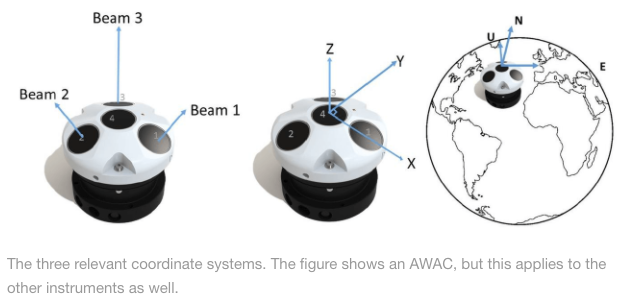

## Function to convert beam coordinates to XYZ to ENU

In [19]:
def beam2enu(beam1vel,beam2vel,beam3vel,beam4vel,beam2xyz,ahrs_rot_mat,pitch):
    ## 01/21/2022     jgradone@marine.rutgers.edu     Initial
    
    ## This function transforms velocity data from beam coordinates to XYZ to ENU. Beam coordinates
    ## are defined as the velocity measured along the three beams of the instrument.
    ## ENU coordinates are defined in an earth coordinate system, where E represents the East-West
    ## component, N represents the North-South component and U represents the Up-Down component.
    ## This function was created for a Nortek AD2CP mounted looking downward on a Slocum glider.
    
    #############################################################################################################
    ## Per Nortek:                                                                                             ##
    ## https://support.nortekgroup.com/hc/en-us/articles/360029820971-How-is-a-coordinate-transformation-done- ##
    #############################################################################################################

    ## "Each instrument has its own unique transformation matrix, based on the transducer geometry.
    ## This matrix can be found, as previously mentioned, in the .hdr file generated when performing
    ## a binary data conversion in the software. Each row of the matrix represents a component in the
    ## instrument’s XYZ coordinate system, starting with X at the top row. Each column represents a beam.
    ## The third and fourth rows of the Vectrino or Signature transformation matrix represent the two
    ## estimates of vertical velocity (Z1 and Z2) produced by the instrument. XYZ coordinates are
    ## defined relative to the instrument, so they do not take into account heading, pitch and roll.
    ## ENU utilizes the attitude measurements to provide an Earth-relative coordinate system."

    ## These are the transformation matricies for up and down cast.
    ## Beam 1: Forward
    ## Beam 2: Port
    ## Beam 3: Aft
    ## Beam 4: Starboard

    ##################################
    ## Transformation matrix layout ##
    ##################################
    # Beam: 1.   2.   3.   4.  
    # X     1X.  2X.  3X.  4X.  
    # Y     1Y.  2Y.  3Y.  4Y.  
    # Z1    1Z1. 2Z1. 3Z1. 4Z1. 
    # Z2    1Z2. 2Z2. 3Z2. 4Z2. 
    ##################################
    
    ################# Input Variables #################
    ## beam1vel     = single ping of velocity from beam 1
    ## beam2vel     = single ping of velocity from beam 2
    ## beam3vel     = single ping of velocity from beam 3
    ## beam4vel     = single ping of velocity from beam 4
    ## beam2xyz_mat = Static transformation matrix from beam to XYZ taking from AD2CP config
    ## ahrs_rot_mat = Dynamic transformation matrix from XYZ to beam, changes depending on heading, pitch, and roll
    ## pitch        = pitch in degrees

    ############################################################################################################
    ## First from beam to XYZ 
    ## If downcast, grab just beams 124 and correction transformation matrix
    if pitch < 0:
        tot_vel = np.matrix([beam1vel, beam2vel, beam4vel])
        beam2xyz_mat = beam2xyz[0:3,(0,1,3)]
    ## If upcast, grab just beams 234 and correction transformation matrix
    elif pitch > 0:
        tot_vel = np.matrix([beam2vel, beam3vel, beam4vel])
        beam2xyz_mat = beam2xyz[0:3,1:4]
    elif pitch == 0: ## Not really sure what to do here, seems unlikely the pitch will be exactly equal to zero
                     ## but I already had it happen once in testing.
        tot_vel = np.matrix([beam2vel, beam3vel, beam4vel])
        beam2xyz_mat = beam2xyz[0:3,1:4]
    
    ## If instrument is pointing down, bit 0 in status is equal to 1, rows 2 and 3 must change sign.
    ## Hard coding this because of glider configuration.
    beam2xyz_mat[1,:] = -beam2xyz_mat[1,:]
    beam2xyz_mat[2,:] = -beam2xyz_mat[2,:]
    
    ## Now convert to XYZ
    xyz     = beam2xyz_mat*tot_vel
     
    ## Grab AHRS rotation matrix for this ping
    xyz2enuAHRS = ahrs_rot_mat.reshape(3,3)
    
    ## Now convert XYZ velocities to ENU, where enu[0,:] is U, enu[1,:] is V, and enu[2,:] is W velocities.
    enu = xyz2enuAHRS*xyz
    
    return(enu)

### Loop to actually convert beam to ENU velocity

In [20]:
# # Initialize final variables with NaNs first
# east             = np.empty([beam1vel.shape[0],beam1vel.shape[1]])
# north            = np.empty([beam1vel.shape[0],beam1vel.shape[1]])
# up               = np.empty([beam1vel.shape[0],beam1vel.shape[1]])
# east[:]          = np.NaN
# north[:]         = np.NaN
# up[:]            = np.NaN


# for k in np.arange(0,beam1vel.shape[1]):
#         enu = beam2enu(beam1vel[:,k],beam2vel[:,k],beam3vel[:,k],beam4vel[:,k],subset_adcp.beam2xyz.values,subset_adcp.ahrs_rot_mat.values[k,:],subset_adcp.pitch.values[k])

#         east[:,k]          = enu[0,:]
#         north[:,k]         = enu[1,:]
#         up[:,k]            = enu[2,:]


### Take a peak at ENU data

In [21]:
# [x,y]=np.meshgrid(tm,bins)
# [bdepth,bbins]=np.meshgrid(pressure,bins)

# by=bdepth+bbins

# fig = plt.figure(figsize=(25,12))

# plt.pcolormesh(x[:,12000:14000],-by[:,12000:14000],east[:,12000:14000])
# plt.plot(tm[12000:14000],-pressure[12000:14000],'k')
# plt.colorbar(label='East-West Velocity')
# plt.gca().xaxis.set_major_formatter(myFmtlong)

# Processing Step 5: QAQC Post-Coordinate Transformation
## Exclude cells that report velocities relative to the glider exceeding 0.5 m/s

In [22]:
# east[east>0.5]   = np.NaN
# north[north>0.5] = np.NaN
# up[up>0.5]       = np.NaN

# Processing Step 6: Run the inversion!

## Start by running on a subset of data first

In [23]:
# [x,y]=np.meshgrid(tm,bins)
# [bdepth,bbins]=np.meshgrid(pressure,bins)

# by=bdepth+bbins

# fig = plt.figure(figsize=(25,12))

# #min_range = 460  ## This is a good 200 meter yo
# #max_range = 7650 ## This is a good 200 meter yo

# min_range = 87300
# max_range = 119000



# plt.pcolormesh(x[:,min_range:max_range],-by[:,min_range:max_range],east[:,min_range:max_range])
# plt.plot(tm[min_range:max_range],-pressure[min_range:max_range],'k')
# plt.colorbar(label='East-West Velocity')
# plt.gca().xaxis.set_major_formatter(myFmtlong)

In [24]:
## Inversion function copied from GitHub repo 01/12/2022
                     
def process_data(U,V,H,dz,u_daverage,v_daverage):
    global O_ls, G_ls, bin_new    
    
    ## Feb-2021 jgradone@marine.rutgers.edu Initial
    ## Jul-2021 jgradone@marine.rutgers.edu Updates for constraints
    
    ## Purpose: Take velocity measurements from glider mounted ADCP and compute
    # shear profiles
    
    ## Outputs:
    # O_ls is the ocean velocity profile
    # G_ls is the glider velocity profile
    # bin_new are the bin centers for the point in the profiles
    # C is the constant used in the constraint equation (Not applicable for
    # real-time processing)
    
    ## Inputs:
    # dz is desired vertical resolution, should not be smaller than bin length
    # H is the max depth of the water column
    # U is measured east-west velocities from ADCP
    # V is measured north-south velocities from ADCP
    # Z is the measurement depths of U and V
    # uv_daverage is depth averaged velocity (Set to 0 for real-time)
    
    ##########################################################################        
    # Take difference between bin lengths for bin size [m]
    bin_size = np.diff(bins)[0]
    bin_num = len(bins)

    # This creates a grid of the ACTUAL depths of the ADCP bins by adding the
    # depths of the ADCP bins to the actual depth of the instrument
    [bdepth,bbins]=np.meshgrid(depth,bins)
    bin_depth = bdepth+bbins  
    Z = bin_depth

    # Set knowns from Equations 19 from Visbeck (2002) page 800
    # Maximum number of observations (nd) is given by the number of velocity
    # estimates per ping (nbin) times the number of profiles per cast (nt)
    nbin = U.shape[0]  # number of programmed ADCP bins per individual profile
    nt   = U.shape[1]  # number of individual velocity profiles
    nd   = nbin*nt      # G dimension (1) 

    # Define the edges of the bins
    bin_edges = np.arange(0,math.floor(np.max(bin_depth)),dz).tolist()

    # Check that each bin has data in it
    bin_count = np.empty(len(bin_edges)-1) # Preallocate memory
    bin_count[:] = np.NaN

    for k in np.arange(len(bin_edges))[:-1]:
        # Create index of depth values that fall inside the bin edges
        ii = np.where((bin_depth > bin_edges[k]) & (bin_depth < bin_edges[k+1]))
        bin_count[k] = len(bin_depth[ii])
        ii = []

    # Create list of bin centers    
    bin_new = [x+dz/2 for x in bin_edges[:-1]]

    # Chop off the top of profile if no data
    ind = np.argmax(bin_count > 0) # Stops at first index greater than 0
    bin_new = bin_new[ind:]        # Removes all bins above first with data
    z1 = bin_new[0]                # Depth of center of first bin with data

    # Create and populate G
    nz = len(bin_new)  # number of ocean velocities desired in output profile
    nm = nz + nt       # G dimension (2), number of unknowns
    # Let's build the corresponding coefficient matrix G 
    G = np.zeros((nd,nm))

    # Indexing of the G matrix was taken from Todd et al. 2012
    for ii in np.arange(0,nt):           # Number of ADCP profiles per cast
        for jj in np.arange(0,nbin):     # Number of measured bins per profile 
            
            # Uctd part of matrix
            G[(nbin*(ii-1))+jj,ii] = 1

            # This will fill in the Uocean part of the matrix. It loops through
            # all Z members and places them in the proper location in the G matrix

            # Find the difference between all bin centers and the current Z value        
            dx = abs(bin_new-Z[ii,jj])

            # Find the minimum of these differences
            minx = np.nanmin(dx)

            # Finds bin_new index of the first match of Z and bin_new    
            idx = np.argmin(dx-minx)

            G[(nbin*(ii-1))+jj,nt+idx] = 1
            del dx, minx, idx


    # Reshape U and V into the format of the d column vector
    d_u = np.flip(U.transpose(),axis=0)
    d_u = d_u.flatten()
    d_v = np.flip(V.transpose(),axis=0)
    d_v = d_v.flatten()


    ##########################################################################
    ## This chunk of code containts the constraints for depth averaged currents
    ## which we likely won't be using for the real-time processing

    # Need to calculate C (Todd et al. 2017) based on our inputs 
    # This creates a row that has the same # of columns as G. The elements
    # of the row follow the trapezoid rule which is used because of the
    # extension of the first bin with data to the surface. The last entry of
    # the row corresponds to the max depth reached by the glider, any bins
    # below that should have already been removed.

    constraint = np.concatenate(([np.zeros(nt)], [z1/2], [z1/2+dz/2], [[dz]*(nz-3)], [dz/2]), axis=None)

    # To find C, we use the equation of the norm and set norm=1 because we
    # desire unity. The equation requires we take the sum of the squares of the
    # entries in constraint.

    sqr_constraint = constraint*constraint
    sum_sqr_constraint = np.sum(sqr_constraint)

    # Then we can solve for the value of C needed to maintain unity 

    C = H*(1/np.sqrt(sum_sqr_constraint))

    # This is where you would add the constraint for the depth averaged
    # velocity from Todd et al., (2011/2017)

    # OG
    du = np.concatenate(([d_u],[C*u_daverage]), axis=None)
    dv = np.concatenate(([d_v],[C*v_daverage]), axis=None)

    # Build Gstar
    # Keep this out because not using depth averaged currents
    Gstar = np.vstack((G, (C/H)*constraint))

    ##########################################################################

    # Build the d matrix
    d = list(map(complex,du, dv))

    ##### Inversion!
    ## If want to do with a sparse matrix sol'n, look at scipy
    #Gs = scipy.sparse(Gstar)
    Gs = Gstar

    ms = np.linalg.solve(np.dot(Gs.conj().transpose(),Gs),Gs.conj().transpose())

    ## This is a little clunky but I think the dot product fails because of
    ## NaN's in the d vector. So, this code will replace NaN's with 0's just
    ## for that calculation    
    sol = np.dot(ms,np.where(np.isnan(d),0,d))

    O_ls = sol[nt:]   # Ocean velocity
    G_ls = sol[0:nt]  # Glider velocity


In [25]:
# # # ###################### Should add this to main function......
# depth = subset_adcp.depth.values
# vx = gl.end_vx[y]
# vy = gl.end_vy[y]
# bins = subset_adcp.bins.values

# process_data(U=east.transpose(),V=north.transpose(),H=1000,dz=10,u_daverage=vx,v_daverage=vy)


In [26]:

# plt.plot(np.real(O_ls),bin_new,label='u - velocity')
# plt.plot(np.imag(O_ls),bin_new,label='v - velocity')
# plt.ylim(1000,0)
# plt.legend()
